In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import pywt
import os,sys
import gpt3_functions

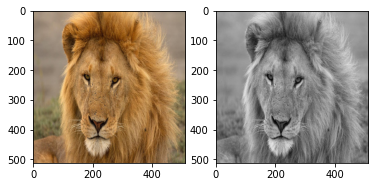

In [102]:
# Chargement de l'image
filename = './figures/06.png'
IMAGE_bgr = cv2.imread(filename)
IMAGE_rgb = cv2.cvtColor(IMAGE_bgr, cv2.COLOR_BGR2RGB)
IMAGE_nb = cv2.cvtColor(IMAGE_rgb, cv2.COLOR_RGB2GRAY)
[H,W] = IMAGE_nb.shape

plt.subplot(121)
plt.imshow(IMAGE_rgb)
plt.subplot(122)
plt.imshow(IMAGE_nb, cmap='gray')
cv2.imwrite('06_nb.png', IMAGE_nb)


plt.show()

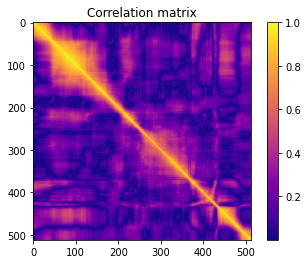

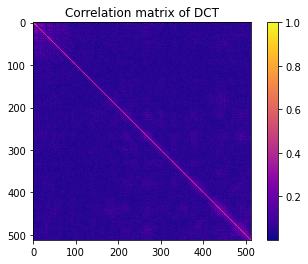

In [116]:
mat_corr = np.corrcoef(IMAGE_nb)
plt.imshow(np.abs(mat_corr), cmap='plasma')
plt.title('Correlation matrix')
plt.colorbar()
plt.show()

mat_corr_dct = np.corrcoef(cv2.dct(IMAGE_nb.astype(np.float32)))
plt.imshow(np.abs(mat_corr_dct), cmap='plasma')
plt.title('Correlation matrix of DCT')
plt.imsave(f'corrMatrix.png', mat_corr, cmap='plasma')
plt.colorbar()
plt.show()

In [104]:
# separate IMAGE_nb into 8x8 blocks
def decoupage88_copilot(mat):
    listImages88 = list()
    for i in range(0, W, 8):
        for j in range(0, H, 8):
            imagette = mat[i:i+8, j:j+8]
            listImages88.append(imagette)
    return listImages88
# reconstruct IMAGE_nb from 8x8 blocks
def reconstruct88_copilot(pList):
    pList_tmp = np.copy(pList).tolist()
    mat = np.zeros((H,W))
    for i in range(0, W, 8):
        for j in range(0, H, 8):
            mat[i:i+8, j:j+8] = pList_tmp.pop(0)
    return mat

In [105]:
listBlocks88 = decoupage88_copilot(IMAGE_nb)
# Irec = reconstruct88_copilot(listBlocks88)
# plt.imshow(Irec, cmap='gray')
# plt.show()

In [106]:
# Calcul de la DCT par blocs de 8x8
listBlocks88_dct = list()
for bloc in listBlocks88:
    dct_block = cv2.dct(bloc.astype(np.float32))
    listBlocks88_dct.append(dct_block)
# dct_par_block = reconstruct88_copilot(listBlocks88_dct)
# plt.imshow((np.abs(dct_par_block)), cmap='plasma')
# print(f'mean of dct par block: {np.mean(dct_par_block)}')
# plt.imsave('dct_par_block.png', np.abs(dct_par_block))
# plt.show()
# plt.imshow((np.abs(cv2.dct(IMAGE_nb.astype(np.float32)))), cmap='plasma')
# plt.imsave('dct.png', np.log(np.abs(cv2.dct(IMAGE_nb.astype(np.float32)))))
# print(f'mean of dct: {np.mean(cv2.dct(IMAGE_nb.astype(np.float32)))}')
# plt.show()

In [107]:
TAUX_COMPRESSION = 15
Z = [[16, 11, 10, 16, 24,  40,  51,  61],
     [12, 12, 14, 19, 26,  58,  60,  55],
     [14, 13, 16, 24, 40,  57,  69,  56],
     [14, 17, 22, 29, 51,  87,  80,  62],
     [18, 22, 37, 56, 68,  109, 103, 77],
     [24, 35, 55, 64, 81,  104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 103, 99]]
Z = np.array(Z)
Z = Z * TAUX_COMPRESSION
# Z = np.ones((8,8))

T_hat = list()
for T in listBlocks88_dct:
     tmp = np.round( np.divide(T,Z) )
     tmp = np.int32(tmp)
     T_hat.append(tmp)

In [108]:
# codage zigzag de chaque block 8 par 8
# the zigzag order is the following : 
# 0 1 5 6 14 15 27 28
# 2 4 7 13 16 26 29 42
# 3 8 12 17 25 30 41 43
# 9 11 18 24 31 40 44 53
# 10 19 23 32 39 45 52 54
# 20 22 33 38 46 51 55 60
# 21 34 37 47 50 56 59 61
# 35 36 48 49 57 58 62 63
def zigzag(image):
    w,h = image.shape
    solution=[[] for i in range(w+h-1)]
    for i in range(w):
        for j in range(h):
            tot=i+j
            if(tot%2 ==0):
                solution[tot].insert(0,image[i][j])
            else:
                solution[tot].append(image[i][j])
            list_zigzag = [j for i in solution for j in i]
    return list_zigzag

def undo_zigzag_copilot(arr):
    mat = np.zeros((8,8))
    mat[0,0] = arr[ 0]
    mat[1,0] = arr[ 1]
    mat[0,1] = arr[ 2]
    mat[0,2] = arr[ 3]
    mat[1,1] = arr[ 4]
    mat[2,0] = arr[ 5]
    mat[3,0] = arr[ 6]
    mat[2,1] = arr[ 7]
    mat[1,2] = arr[ 8]
    mat[0,3] = arr[ 9]
    mat[0,4] = arr[10]
    mat[1,3] = arr[11]
    mat[2,2] = arr[12]
    mat[3,1] = arr[13]
    mat[4,0] = arr[14]
    mat[5,0] = arr[15]
    mat[4,1] = arr[16]
    mat[3,2] = arr[17]
    mat[2,3] = arr[18]
    mat[1,4] = arr[19]
    mat[0,5] = arr[20]
    mat[0,6] = arr[21]
    mat[1,5] = arr[22]
    mat[2,4] = arr[23]
    mat[3,3] = arr[24]
    mat[4,2] = arr[25]
    mat[5,1] = arr[26]
    mat[6,0] = arr[27]
    mat[7,0] = arr[28]
    mat[6,1] = arr[29]
    mat[5,2] = arr[30]
    mat[4,3] = arr[31]
    mat[3,4] = arr[32]
    mat[2,5] = arr[33]
    mat[1,6] = arr[34]
    mat[0,7] = arr[35]
    mat[1,7] = arr[36]
    mat[2,6] = arr[37]
    mat[3,5] = arr[38]
    mat[4,4] = arr[39]
    mat[5,3] = arr[40]
    mat[6,2] = arr[41]
    mat[7,1] = arr[42]
    mat[7,2] = arr[43]
    mat[6,3] = arr[44]
    mat[5,4] = arr[45]
    mat[4,5] = arr[46]
    mat[3,6] = arr[47]
    mat[2,7] = arr[48]
    mat[3,7] = arr[49]
    mat[4,6] = arr[50]
    mat[5,5] = arr[51]
    mat[6,4] = arr[52]
    mat[7,3] = arr[53]
    mat[7,4] = arr[54]
    mat[6,5] = arr[55]
    mat[5,6] = arr[56]
    mat[4,7] = arr[57]
    mat[5,7] = arr[58]
    mat[6,6] = arr[59]
    mat[7,5] = arr[60]
    mat[7,6] = arr[61]
    mat[6,7] = arr[62]
    mat[7,7] = arr[63]
    return np.int32(mat.T)

def undo_zigzag(list_zigzag):
    mat = np.zeros((8,8))
    
    return mat

# # print(T_hat[999])
# plt.subplot(1,2,1)
# plt.imshow(T_hat[999], cmap='gray')
# # print(undo_zigzag_copilot(zigzag(T_hat[999])))
# plt.subplot(1,2,2)
# plt.imshow(undo_zigzag_copilot(zigzag(T_hat[999])), cmap='gray')
# plt.show()


In [109]:
# ecriture en zigzag de chaque block 8 par 8
listBlocks88_dct_zigzag = list()
for bloc in T_hat:
    listBlocks88_dct_zigzag.append(zigzag(bloc))
    
max_all_blocks = np.max(listBlocks88_dct_zigzag)
print(f'Max of all blocks : {max_all_blocks}')
max_all_blocks_bin = bin(max_all_blocks)
print(f'Binary conversion of max : {max_all_blocks_bin}')

Max of all blocks : 7
Binary conversion of max : 0b111


In [110]:
flagVal = 'V'
flagBlock = 'B'

with open('compressed_nvx.txt', 'w') as f:
    for liste in listBlocks88_dct_zigzag:
        f.write(str(liste) + '\n')


size_compressed = os.path.getsize('compressed_nvx.txt') / 1024
print(f'Size of compressed file :  {round(size_compressed, 2)} Kbyte')

size_init = os.path.getsize('06_nb.png') / 1024
print(f'Size of initial file    :  {round(size_init, 2)} Kbyte')

size_var_init = sys.getsizeof(IMAGE_nb) / 1024
print(f'Size of initial image   :  {round(size_var_init, 2)} Kbyte')

size_var_compressed = sys.getsizeof(listBlocks88_dct_zigzag) / 1024
print(f'Size of compressed image:  {round(size_var_compressed, 2)} Kbyte')

compression_ratio = size_var_init / size_var_compressed
print(f'Compression ratio       :  {round(compression_ratio, 2)}')

Size of compressed file :  776.36 Kbyte
Size of initial file    :  177.52 Kbyte
Size of initial image   :  256.12 Kbyte
Size of compressed image:  32.27 Kbyte
Compression ratio       :  7.94


## **Décodage** de l'image compressée

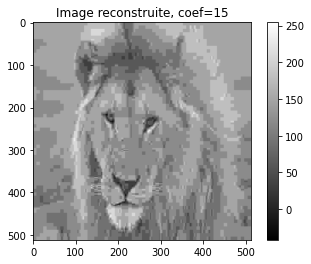

In [111]:
# undo zigzag
listBlocks88_unzigzag = list()
for bloc in listBlocks88_dct_zigzag:
    listBlocks88_unzigzag.append(undo_zigzag_copilot(bloc))

# undo quantification
listBlocks88_quantifie = list()
for T in listBlocks88_unzigzag:
    listBlocks88_quantifie.append(T*Z) 

# undo dct
listBlocks88_quantifie_idct = list()
for bloc in listBlocks88_quantifie:
    tmp = cv2.idct(bloc.astype(np.float32))
    listBlocks88_quantifie_idct.append(tmp)

# Reconstruction de l'image
Irec = reconstruct88_copilot(listBlocks88_quantifie_idct)
plt.imshow(Irec, cmap='gray')
plt.title(f'Image reconstruite, coef={TAUX_COMPRESSION}')
cv2.imwrite(f'Irec_coef={TAUX_COMPRESSION}.png', Irec)
plt.colorbar()
plt.show()

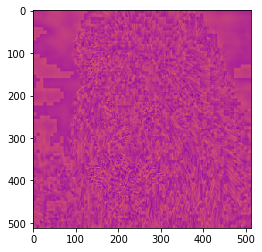

0.02536769207304701


In [112]:
diff = IMAGE_nb - Irec
plt.imshow(diff, cmap='plasma')
plt.show()
print(np.mean(diff))